# Flex Lux vs 50% Intro Offer (Clx 12, Clx 6, Pops 7) AB Test

* A: 50% off intro package to either Classics 12, Classics 6 or Pops 7
* B: Flex Lux

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import os
import pandas as pd
import numpy as np
from numpy.random import beta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

---
### Globals

In [3]:
N_SAMPLES = 1000000 # number of monte carlo sims
PRIOR_A = 1.0 # no prior assumptions made
PRIOR_B = 1.0 # no prior assumptions made
PATH_DATA = 'U://projects/ab_experiments/flex_v_50perc_intro_offer/data'

---
### Data Imports

#### Experiment List Data

In [4]:
lists = pd.read_csv(PATH_DATA + '/experiment_lists.csv')

In [5]:
list_a = set(lists.loc[lists['treatment'] == 'A']['customer_no'])
list_b = set(lists.loc[lists['treatment'] == 'B']['customer_no'])

#### Subscription Data

In [72]:
pop_sub = pd.read_csv(PATH_DATA + '/pop_sub.csv', encoding="ISO-8859-1")
clx_sub = pd.read_csv(PATH_DATA + '/clx_sub.csv', encoding="ISO-8859-1")
flex_lux = pd.read_csv(PATH_DATA + '/flex_lux.csv', encoding="ISO-8859-1")

In [73]:
pop_sub_cust = set(pop_sub['customer_no'])
clx_sub_cust = set(clx_sub['customer_no'])
flx_sub_cust = set(flex_lux['customer_no'])

In [75]:
a_all_subs = pop_sub_cust.union(clx_sub_cust)
b_all_subs = flx_sub_cust

---
### Observed Results

In [78]:
a_conversions = len(list_a) - len(list_a - a_all_subs)

In [79]:
b_conversions = len(list_b) - len(list_b - b_all_subs)

In [147]:
print(f"A: {len(list_a)}, with {a_conversions} conversions. B: {len(list_b)}, with {b_conversions} conversions.")

A: 27730, with 22 conversions. B: 28864, with 28 conversions.


In [80]:
# A experiment
A_successes = a_conversions
A_failures = len(list_a) - A_successes

# B experiment
B_successes = b_conversions
B_failures = len(list_b) - B_successes

Monte Carlo for beta distribution

In [81]:
A_posterior = beta(A_successes + PRIOR_A,
                  A_failures + PRIOR_B,
                  N_SAMPLES)

B_posterior = beta(B_successes + PRIOR_A,
                  B_failures + PRIOR_B,
                  N_SAMPLES)

### Plot the sample distributions

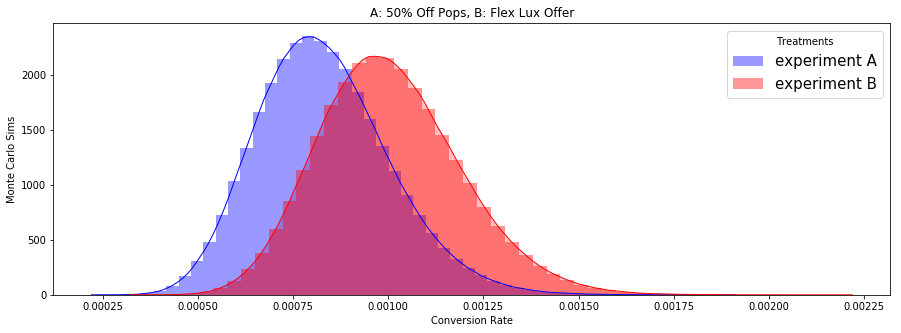

In [82]:
# Plot setup
plt.figure(figsize=[15,5])

# Plotting data
sns.distplot(A_posterior, hist=True, kde=True,
            color='blue', kde_kws={'linewidth':1},
            label='experiment A')
sns.distplot(B_posterior, hist=True, kde=True,
            color='red', kde_kws={'shade': True,'linewidth': 1},
            label='experiment B')

# Plotting formatting
plt.legend(prop={'size': 15}, title='Treatments')
plt.title('A: 50% Off Pops, B: Flex Lux Offer')
plt.xlabel('Conversion Rate')
plt.ylabel('Monte Carlo Sims')
plt.show()

In [83]:
A_mean = np.mean(A_posterior) * 100
B_mean = np.mean(B_posterior) * 100

In [84]:
A_mean, B_mean

(0.08296752489668845, 0.10045506701113911)

### Plot Relative Difference between B and A

In [98]:
# Calculate relative difference
relative_difference = (B_posterior - A_posterior) / A_posterior

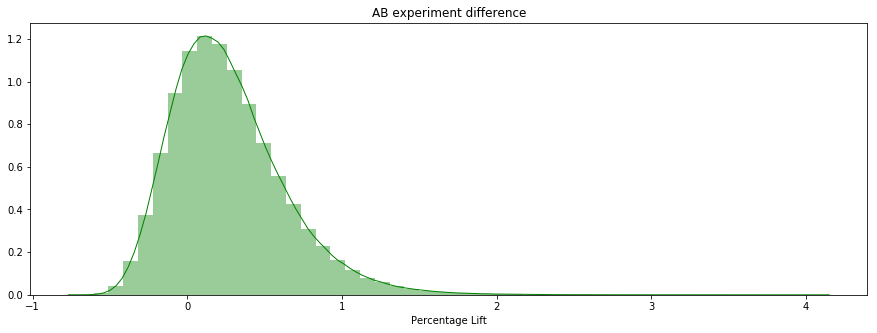

In [99]:
# Plot setup
plt.figure(figsize=[15,5])

# Plotting data
sns.distplot(relative_difference, hist=True, kde=True,
            color='green', kde_kws={'linewidth':1},
            label='experiment difference')


# Plotting formatting
plt.title('AB experiment difference')
plt.xlabel('Percentage Lift')
plt.show()

In [100]:
expected_lift = np.percentile(relative_difference, 50)
std_dev = stats.sem(relative_difference)

In [95]:
target = 0
counter = 0
i = np.percentile(relative_difference, counter)
while i < target:
    counter += 1
    i = np.percentile(relative_difference, counter)
print(f"We are {100 - counter}% certain that treatment B - Flex Lux - converted better than treatment A")

We are 75% certain that treatment B - Flex Lux - converted better than treatment A


In [110]:
print(f"Our expected lift is {round(expected_lift * 100, 1)}%")

Our expected lift is 21.5%


### ROI

In [120]:
a_sub = pd.concat([pop_sub, clx_sub])
b_sub = flex_lux.copy()

Isolate for subscribers that are a part of the experiment for treatment A and B

In [126]:
a_sub = a_sub.loc[a_sub['customer_no'].isin(list_a)]
b_sub = b_sub.loc[b_sub['customer_no'].isin(list_b)]

Aggregate total paid amount

In [128]:
a_paid = a_sub.groupby(['customer_no']).agg({
    'total_amt': sum
})

b_paid = b_sub.groupby(['customer_no']).agg({
    'total_amt': sum
})

Determine average paid amount for the package

In [133]:
a_pricing_avg = np.mean(a_paid['total_amt'])
b_pricing_avg = np.mean(b_paid['total_amt'])

Determine ROI

In [154]:
a_ret = len(list_a) * A_mean / 100 * a_pricing_avg

In [161]:
rev_increase = a_ret * ((1 + expected_lift)) - a_ret